In [52]:
import time 
import numpy as np 
import pandas as pd
import os 
import pandas_ta as ta
import ccxt
from datetime import datetime
from xgboost import XGBRegressor
import optuna 
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Inference 

Get inference data: time 2023/12/22 

In [4]:
# inference 
# get inference data 
bitget = ccxt.bitget()
ohlcv = bitget.fetch_ohlcv("BTC/USDT:USDT", "4h")
chart_df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

def preprocess(df):
    bitget = ccxt.bitget()
    dates = df["timestamp"].values
    utc_timestamps = []
    for timestamp in dates:
        # Convert to ISO 8601 format
        date_string = bitget.iso8601(int(timestamp))
        # Convert to datetime object without timezone conversion
        date_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%fZ")
        # Format to string if needed (optional)
        formatted_utc_time = date_object.strftime("%Y-%m-%d %H:%M:%S")
        utc_timestamps.append(formatted_utc_time)
    # Update DataFrame
    df["date"] = utc_timestamps
    df = df.drop(columns={"timestamp"})
    return df

chart_df = preprocess(chart_df)

In [7]:
ground_truth = chart_df["close"].values[:-1] 

# XGBoost predictions

Because of data preprocessing (+feature engineering) for XGBoost, we end up with 61 test data for XGBoost. We compare the same ranges for both the ground truth and autogluon time series.  

In [44]:
# load XGBoost model 
test_xgb = XGBRegressor()
test_xgb.load_model("XGBoost_regression_optuna")

In [45]:
# get XGBoost predictions 
hours, days, months = [], [], [] 
for dt in tqdm(chart_df["date"]): 
    dtobj = pd.to_datetime(dt) 
    hour = dtobj.hour 
    day = dtobj.day 
    month = dtobj.month 
    hours.append(hour) 
    days.append(day) 
    months.append(month) 

chart_df["hours"] = hours 
chart_df["days"] = days 
chart_df["months"] = months 

# add some technical indicators 
chart_df.set_index(pd.DatetimeIndex(chart_df["date"]), inplace=True)
# feature engineering 
chart_df["bop"] = chart_df.ta.bop(lookahead=False)
chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
chart_df["vwap"] = chart_df.ta.vwap(lookahead=False) 
chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100.0 
chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
chart_df["hwma"] = chart_df.ta.hwma(lookahead=False) 
chart_df["hwma/close"] = chart_df["hwma"] / chart_df["close"] 
for l in range(1, 12): 
    for col in ["open", "high", "low", "close", "volume", "vwap"]: 
        val = chart_df[col].values 
        val_ret = [None for _ in range(l)] 
        for i in range(l, len(val)):
            if val[i-l] == 0: 
                ret = 1 
            else:
                ret = val[i] / val[i-l] 
            val_ret.append(ret) 
        chart_df["{}_change_{}".format(col, l)] = val_ret 
chart_df.drop(columns={"date"}, inplace=True) 
chart_df.dropna(inplace=True) 

  0%|          | 0/61 [00:00<?, ?it/s]

/tmp/ipykernel_669/176029162.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False)


In [18]:
XGB_predictions = [] 
for i in tqdm(range(chart_df.shape[0]-1), position=0, leave=True): 
    cur_input = chart_df.iloc[i].values.reshape((1, -1)) 
    y_hat = test_xgb.predict(cur_input)[0] 
    XGB_predictions.append(y_hat) 

  0%|          | 0/60 [00:00<?, ?it/s]

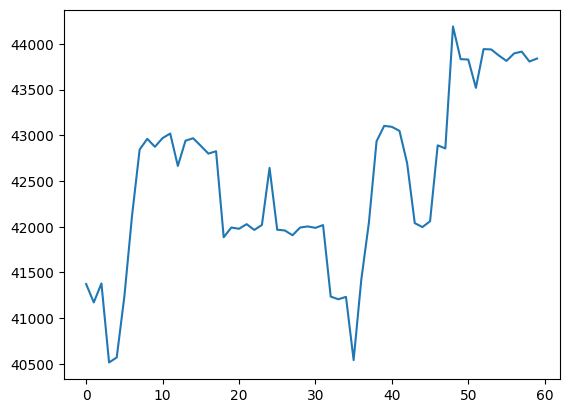

In [21]:
plt.plot(XGB_predictions)

In [47]:
test_ground_truth = ground_truth[-60:] 

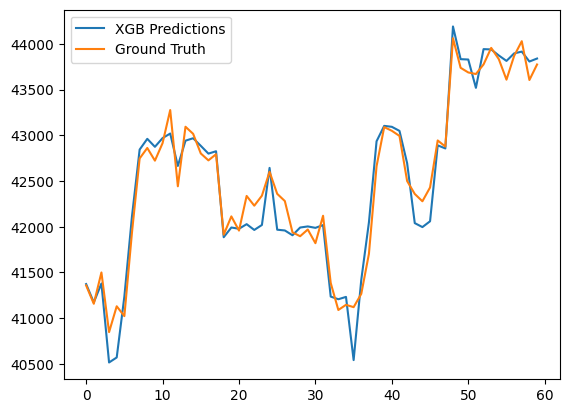

In [50]:
plt.plot(XGB_predictions, label="XGB Predictions")
plt.plot(test_ground_truth, label="Ground Truth")
plt.legend()

In [55]:
mae = mean_absolute_error(test_ground_truth, XGB_predictions)
rmse = np.sqrt(mean_squared_error(test_ground_truth, XGB_predictions))
mape = np.mean(np.abs((test_ground_truth - XGB_predictions) / test_ground_truth)) * 100

print(f"MAPE: {mape:.2f}%") 
print(f"MAE: {mae:.2f}") 
print(f"RMSE: {rmse:.2f}") 

MAPE: 0.37%
MAE: 156.13
RMSE: 202.84
